In [63]:
# This program generates a (S,R) Inventory restocking policy,
# R = Restocking level when an order is activated
# S = Stock level that wants to be achieved.
# This model can have only 1 order at a time

# This model keeps track of the backlog

# Process Oriented Coding

# Based on:
# https://www.youtube.com/watch?v=Kmu9DNQamLw

# Daniel A. Sepulveda Estay, PhD
# Technical University of Denmark, 2020

import simpy
import numpy as np

In [94]:
# Define the variables of the model
# Unit of time: day
lead_time = 2.0  # days of Lead_time for orders of #num_ordered
cost_ordering = 50  # Cost of making an order per order
cost_holding = 2 # Cost of Holding inventory per day
cost_backlog = 4 # Cost of owing inventory per day 
policy_cutoff = 20 # (s) Minimum amount of stock when an order is activated
policy_inventory_target = 100 # (S) Amount of stock that can be maintained in the Warehouse
running_time = 20000 # days that the simulation will be running
sales_price = 100 # units of Money per item sold

# Define the processes in the Model
# 1.- The warehouse process which considers 
#    a) the arrival time of a new order, 
#    b) calculation of holding costs and backlog costs
#    c) the demand quantity for that new order
#    d) Deliver the (demad+backlog) quantity as much as possible
#    e) Calculatio of backlog
#    e) generation of order if inventory is below the cutoff quantity

def warehouse_run(env, order_cutoff, order_target):
    global inventory, balance, backlog, num_ordered
    inventory = order_target
    backlog = 0
    balance = 0.0
    Cinventory = 0.0
    Cbacklog = 0.0
    num_ordered = 0
    # print('Initial Stock: {}'.format(inventory))
    while True:
        # a) Generate arrival time of next customer demand (Exponential Distribution Function)
        interarrival = generate_interarrival()
        # Wait until this arrival time
        yield env.timeout(interarrival)
        # b) Calculate the holding costs and backlog costs
        balance -= inventory*cost_holding*interarrival
        Cinventory += inventory*cost_holding*interarrival
        Cbacklog += backlog*cost_backlog*interarrival
        # c) Generate a demand quantity (Uniform Distribution Function)
        demand = generate_demand()
        # d) Deliver inventory for cases where there is enouh ibnventory and where there is not enough
        if (demand+backlog)<=inventory:
            total_due = demand+backlog
            balance += sales_price*demand
            inventory -= (demand+backlog)
            backlog = 0
            # print('Time: {:.2f}. Demand: {}. Sold: {}. ENOUGH INV. Inv: {}. BL: {}'.format(env.now, demand, total_due, inventory, backlog))
        elif (demand+backlog) > inventory and demand < inventory:
            total_due = demand+backlog
            balance += sales_price*inventory
            backlog -= (inventory - demand)
            # print('Time: {:.2f}. Demand:{}. Sold: {} units. OUT OF STOCK-DECR.BL. Inv: {}. BL: {}'.format(env.now, total_due, inventory, 0, backlog))
            inventory = 0
        else:
            balance += sales_price*inventory
            backlog += (demand-inventory)
            # print('Time: {:.2f}. Demand: {}. Sold: {} units. OUT OF STOCK-INCR.BL. Inv: {}. BL: {}'.format(env.now, demand, inventory, 0, backlog))
            inventory = 0
            
        # e) See if it is necessary to generate a new order (Function)  
        if inventory < order_cutoff and num_ordered==0:
            env.process(handle_order(env, order_target))
    
def handle_order(env, order_target):
    global inventory, balance, num_ordered
    # Order stock necessary to cover the difference from the policy_inventory_target
    num_ordered = order_target - inventory
    # print('Time: {:.2f} Order: {}. Inv: {}. BL: {}'.format(env.now, num_ordered, inventory, backlog))
    # Calculate and account the cost of ordering
    balance -= cost_ordering*num_ordered
    # wait the lead time for orders, of lead_time time units
    yield env.timeout(lead_time)
    #receive the order by increasing the inventory
    inventory += num_ordered
    # print('Time: {:.2f} Received: {}. Inv: {}. BL: {}'.format(env.now, num_ordered, inventory, backlog))
    # leave the system ready for a new order
    num_ordered = 0
    
    
def generate_interarrival():
    # The arrivals of new customers is expenential with a lambda=5 persons/time
    return np.random.exponential(1./7.0)

def generate_demand():
    return np.random.randint(1,5) # value integrer between 1 and 5 units/time

# Define the observational variables
obs_time = []
inventory_level = [] # This balance starts at policy_inventory_target units of inventory
backlog_level = []
balance_level = []  # This balance level starts at 0 units of money
av_balance = []

def observe(env):
    global inventory, balance, backlog
    
    while True:
        obs_time.append(env.now)
        inventory_level.append(inventory)
        balance_level.append(balance)
        backlog_level.append(backlog)
        if env.now == 0:
            av_balance.append(0)
        else:
            av_balance.append(balance/env.now)
        yield env.timeout(0.1)
        

In [95]:
np.random.seed(1)
env = simpy.Environment()
env.process(warehouse_run(env, policy_cutoff, 50))
env.process(observe(env))
env.run(until=running_time)

<function matplotlib.pyplot.show(*args, **kw)>

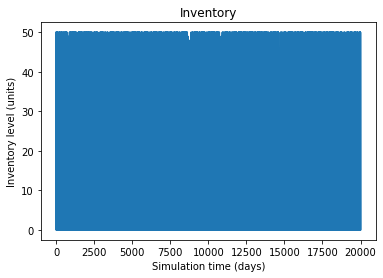

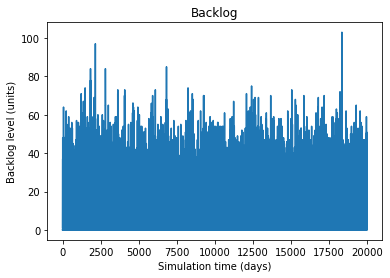

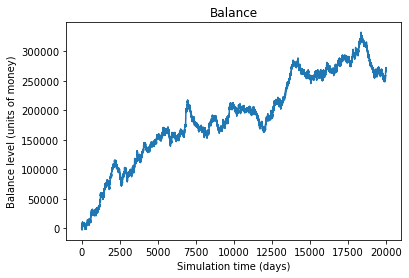

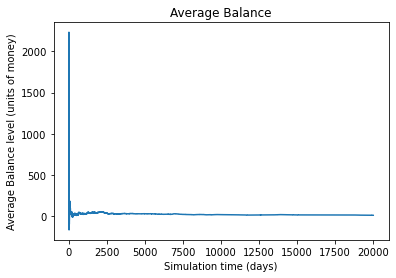

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.step(obs_time, inventory_level, where='post')
plt.xlabel('Simulation time (days)')
plt.ylabel('Inventory level (units)')
plt.title('Inventory')
plt.show

plt.figure()
plt.step(obs_time, backlog_level, where='post')
plt.xlabel('Simulation time (days)')
plt.ylabel('Backlog level (units)')
plt.title('Backlog')
plt.show

plt.figure()
plt.step(obs_time, balance_level, where='post')
plt.xlabel('Simulation time (days)')
plt.ylabel('Balance level (units of money)')
plt.title('Balance')
plt.show

plt.figure()
plt.step(obs_time, av_balance, where='post')
plt.xlabel('Simulation time (days)')
plt.ylabel('Average Balance level (units of money)')
plt.title('Average Balance')
plt.show

In [97]:
balance

266063.86484234146